In [2]:
import sys
import math
import pandas as pd
import numpy as np
import causalimpact as ci
import json
import matplotlib.pyplot as plt
import warnings

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import reader_writer
from Utilities import query_engines

rw = reader_writer.Reader_Writer()

# SPM Group creator

**Context**
<br>
The POPs Team wants to run some tests with different partners to see which level of aggressiveness works best. In order to do this, they need to divide their sample data into two groups - a CONTROL group and a TREAT group.
<br>
<br>
To resolve the question of what is the best grouping, we use this script for each partner
<br>
<br>
A fake synthtetic control analysis is used to decide which is the best partners' grouping. After an imaginary TREATMENT we perform a synthetic control analysis to the CONTROL and TREAT group. The least difference between CONTROL and TREAT is the group that we consider to be the best predictor. In terms of p-value, this happens when the p-value is the highest value.
<br>
<br>
**Approach**
For synthetic control analysis I use the following convetions:
- 80% TREAT, 20% CONTROL
- The universe of stores evaluates are the store addresess with more ellegible products to be deactivated by the SPM. These are products in the range of [0%,30%] PNA. 

### Store universe definition

In [10]:
df = rw.csv_read_file('selected_partners.csv')
df = df[['store_address_id']]
print('There are {} distinct store addresses'.format(df['store_address_id'].nunique()))

There are 509 distinct store addresses


In [23]:
# Query de data of the store addresses

# Parameters
start_date = '2023-07-10'
end_date = '2023-09-17'
store_addresses = ",".join(str(val) for val in df['store_address_id'].unique().tolist())
params = [
    {'name':'store_addresses', 'value':store_addresses}
    ,{'name':'start_date', 'value':start_date}
    ,{'name':'end_date', 'value':end_date}
]

# Query
query = query_engines.QueryEngines(
    query='SPM/SPM_synthetic.sql', 
    del1='--v3', 
    del2='--end_v3',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_pna = query.query_run_starbust()
print('There are {} distinct dates'.format(d_pna['order_descriptors.order_activated_local_date'].nunique()))
print("Min Date = {}".format(d_pna['order_descriptors.order_activated_local_date'].min()))
print("Max Date = {}".format(d_pna['order_descriptors.order_activated_local_date'].max()))
print('There are {} store addresses'.format(d_pna['order_descriptors.store_address_id'].nunique()))
d_pna.head()

There are 70 distinct dates
Min Date = 2023-07-10
Max Date = 2023-09-17
There are 482 store addresses


,order_descriptors.store_address_id,order_descriptors.order_activated_local_date,number_of_products_with_pna,number_of_placed_products,number_of_orders,number_of_delivered_orders,total_quantity_placed,products_value_placed
0,603358,2023-09-06,20,338,52,51,819,695.843489
1,603358,2023-08-24,9,279,47,45,735,605.260713
2,603358,2023-07-19,14,308,48,48,886,650.532781
3,603358,2023-07-17,28,450,64,59,1329,1019.365319
4,603358,2023-07-10,18,310,41,38,896,652.367842


In [41]:
d_pna['order_descriptors.store_address_id']==

,order_descriptors.store_address_id,order_descriptors.order_activated_local_date,number_of_products_with_pna,number_of_placed_products,number_of_orders,number_of_delivered_orders,total_quantity_placed,products_value_placed
0,603358,2023-09-06,20,338,52,51,819,695.843489
1,603358,2023-08-24,9,279,47,45,735,605.260713
2,603358,2023-07-19,14,308,48,48,886,650.532781
3,603358,2023-07-17,28,450,64,59,1329,1019.365319
4,603358,2023-07-10,18,310,41,38,896,652.367842
...,...,...,...,...,...,...,...,...
31617,187,2023-07-21,2,73,11,11,101,324.250000
31618,187,2023-09-03,26,242,29,26,337,853.680000
31619,187,2023-07-29,4,83,14,13,158,465.740000
31620,187,2023-08-03,12,135,14,14,191,458.560000


### Groups creation

In [22]:
# Parameters
start_pre = "2023-07-10"; end_pre = "2023-09-03"
start_post = "2023-09-04"; end_post = "2023-09-17"
target_columns = ['number_of_placed_products', 'perc_products_pna', 'UIPO']
p_control = 0.2 # Probability that to be control gropup
p_treat = 1-p_control # Probability to be treat group
num_iterations = 5

# Take the unique labels and create a dataframe
series = pd.Series(d_pna['order_descriptors.store_address_id'].unique())
df_groups = pd.DataFrame({'order_descriptors.store_address_id': series})
labels = ['Treat', 'Control']

# Create an empty DataFrame to store the results
results_dict = {}

for i in range(num_iterations):
    # Create the new groups and prepare data
    df_groups['Group'] = np.random.choice(labels, size=len(df_groups), p=[p_treat, p_control])
    df_groups_json = df_groups.to_json(orient='split') # Used to later store the results
    df_group_assigned = pd.merge(d_pna, df_groups, on='order_descriptors.store_address_id', how='left')
    
    # Data period range
    pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
    post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
    
    # -TO BE EDITED-
    # Group by and compute the metrics
    df_ready = df_group_assigned.groupby(['order_descriptors.order_activated_local_date', 'Group'])['number_of_products_with_pna','number_of_placed_products','number_of_orders'].sum().reset_index()
    df_ready['perc_products_pna'] = df_ready['number_of_products_with_pna']/df_ready['number_of_placed_products']
    df_ready['UIPO'] = df_ready['number_of_placed_products']/df_ready['number_of_orders']

    # Compute Causal Impact for each target column
    p_value_results = []
    for col in target_columns:
        df_pivot = df_ready.pivot(index='order_descriptors.order_activated_local_date', columns='Group', values=col)
        df_pivot.dropna(how='any', inplace=True)
        model = ci.CausalImpact(df_pivot[['Control', 'Treat']],pre_period,post_period)
        p_value_results.append(model.p_value)
    # Add the results to the dictionary
    results_dict[df_groups_json] = p_value_results
    
# Convert the dictionary to a dataframe
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'Group'})
# Set the column names
column_names = ['p_value_' + str(i) for i in target_columns]
results_df.columns = ['Group'] + column_names

# -TO BE EDITED-
# Compute the ranking based on p values
results_df['rank_p_value_number_of_placed_products'] = results_df['p_value_number_of_placed_products'].rank(method='dense', ascending=False)
results_df['rank_p_value_perc_products_pna'] = results_df['p_value_perc_products_pna'].rank(method='dense', ascending=False)
results_df['rank_p_value_UIPO'] = results_df['p_value_UIPO'].rank(method='dense', ascending=False)
results_df['total_rank'] = results_df['rank_p_value_number_of_placed_products'] + results_df['rank_p_value_perc_products_pna'] + results_df['rank_p_value_UIPO']
results_df.sort_values(by='total_rank', ascending=True, inplace=True)

warnings.filterwarnings('ignore')

results_df

C:\Users\Jordi Cremades\AppData\Local\Temp\ipykernel_25864\4056854436.py:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_ready = df_group_assigned.groupby(['order_descriptors.order_activated_local_date', 'Group'])['number_of_products_with_pna','number_of_placed_products','number_of_orders'].sum().reset_index()
c:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  war

,Group,p_value_number_of_placed_products,p_value_perc_products_pna,p_value_UIPO,rank_p_value_number_of_placed_products,rank_p_value_perc_products_pna,rank_p_value_UIPO,total_rank
4,"{""columns"":[""order_descriptors.store_address_i...",0.492507,0.490509,0.000000,1.0,1.0,5.0,7.0
0,"{""columns"":[""order_descriptors.store_address_i...",0.266733,0.000999,0.274725,3.0,4.0,1.0,8.0
1,"{""columns"":[""order_descriptors.store_address_i...",0.034965,0.019980,0.083916,5.0,3.0,2.0,10.0
2,"{""columns"":[""order_descriptors.store_address_i...",0.374625,0.000000,0.053946,2.0,5.0,3.0,10.0
3,"{""columns"":[""order_descriptors.store_address_i...",0.215784,0.225774,0.022977,4.0,2.0,4.0,10.0


###  Group final selection

In [35]:
# Select the rows corresponding to a given group configuration
min_rank_index = results_df['total_rank'].idxmin()

# Params
idx_to_analyse = min_rank_index

group_config = results_df.loc[idx_to_analyse, 'Group']
df_group_config = pd.read_json(group_config, orient='split')
df_group_assigned = pd.merge(d_pna, df_group_config, on='order_descriptors.store_address_id', how='left') # We just keep the best group configuration

# Calculation of the final model selection - TO BE EDITED - 
df_ready = df_group_assigned.groupby(['order_descriptors.order_activated_local_date', 'Group'])['number_of_products_with_pna','number_of_placed_products','number_of_orders'].sum().reset_index()
df_ready['perc_products_pna'] = df_ready['number_of_products_with_pna']/df_ready['number_of_placed_products']
df_ready['UIPO'] = df_ready['number_of_placed_products']/df_ready['number_of_orders']

# perc_products_pna
df_pivot = df_ready.pivot(index='order_descriptors.order_activated_local_date', columns='Group', values='perc_products_pna')
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
model1 = ci.CausalImpact(df_pivot, pre_period, post_period)

# UIPO
df_pivot = df_ready.pivot(index='order_descriptors.order_activated_local_date', columns='Group', values='UIPO')
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
model2 = ci.CausalImpact(df_pivot, pre_period, post_period)

# number_of_placed_products
df_pivot = df_ready.pivot(index='order_descriptors.order_activated_local_date', columns='Group', values='number_of_placed_products')
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]
model3 = ci.CausalImpact(df_pivot, pre_period, post_period)

warnings.filterwarnings('ignore')

perc_products_pna, with a p_value of 0.46553446553446554


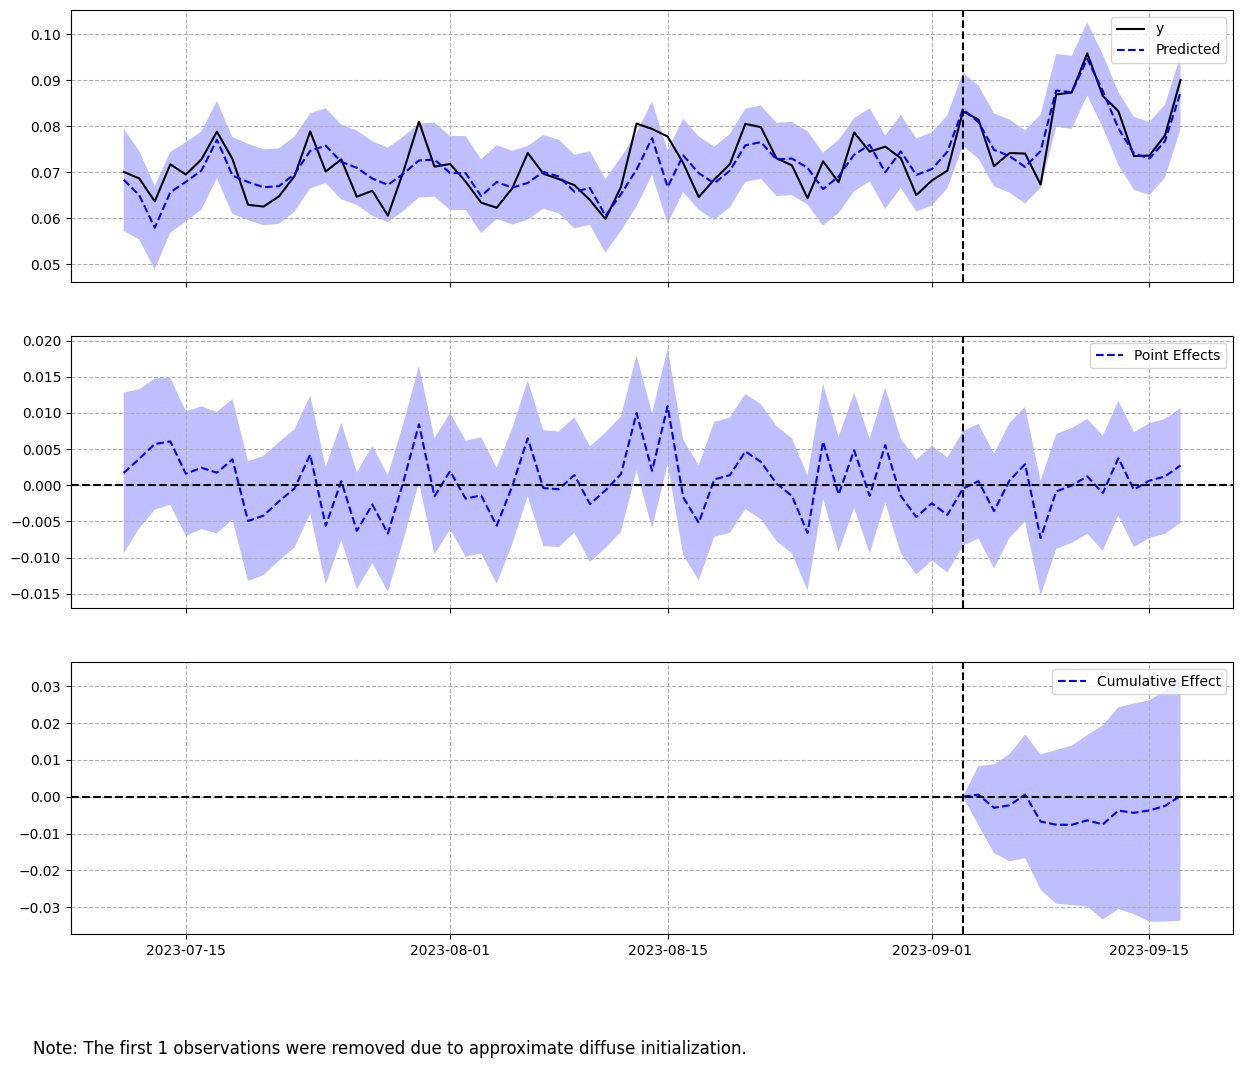

In [36]:
print('perc_products_pna, with a p_value of {}'.format(model1.p_value))
model1.plot()

UIPO, with a p_value of 0.0


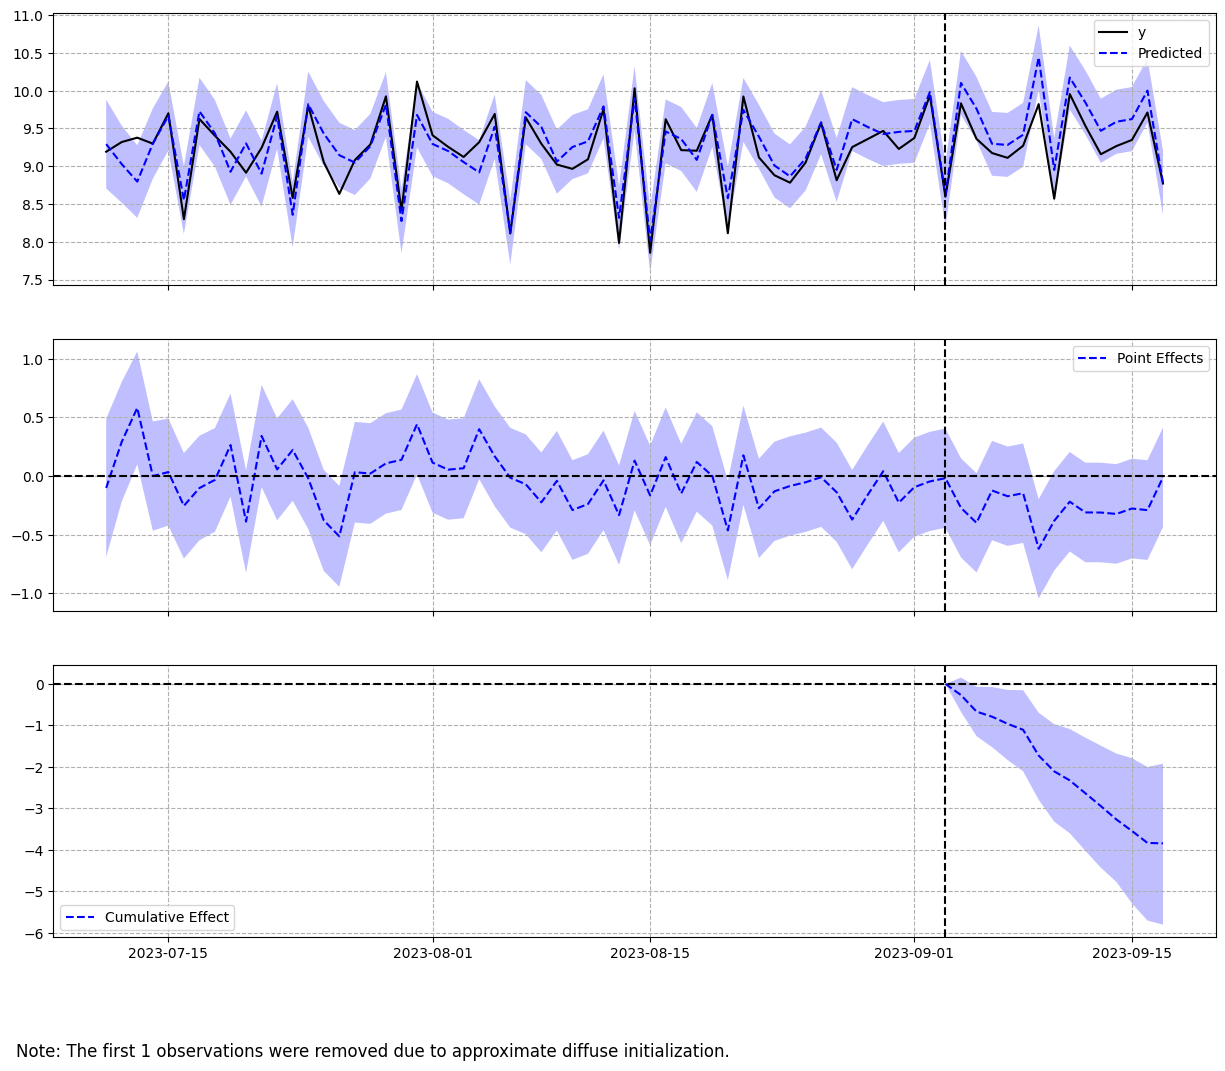

In [37]:
print('UIPO, with a p_value of {}'.format(model2.p_value))
model2.plot()

number_of_placed_products 0.4785214785214785


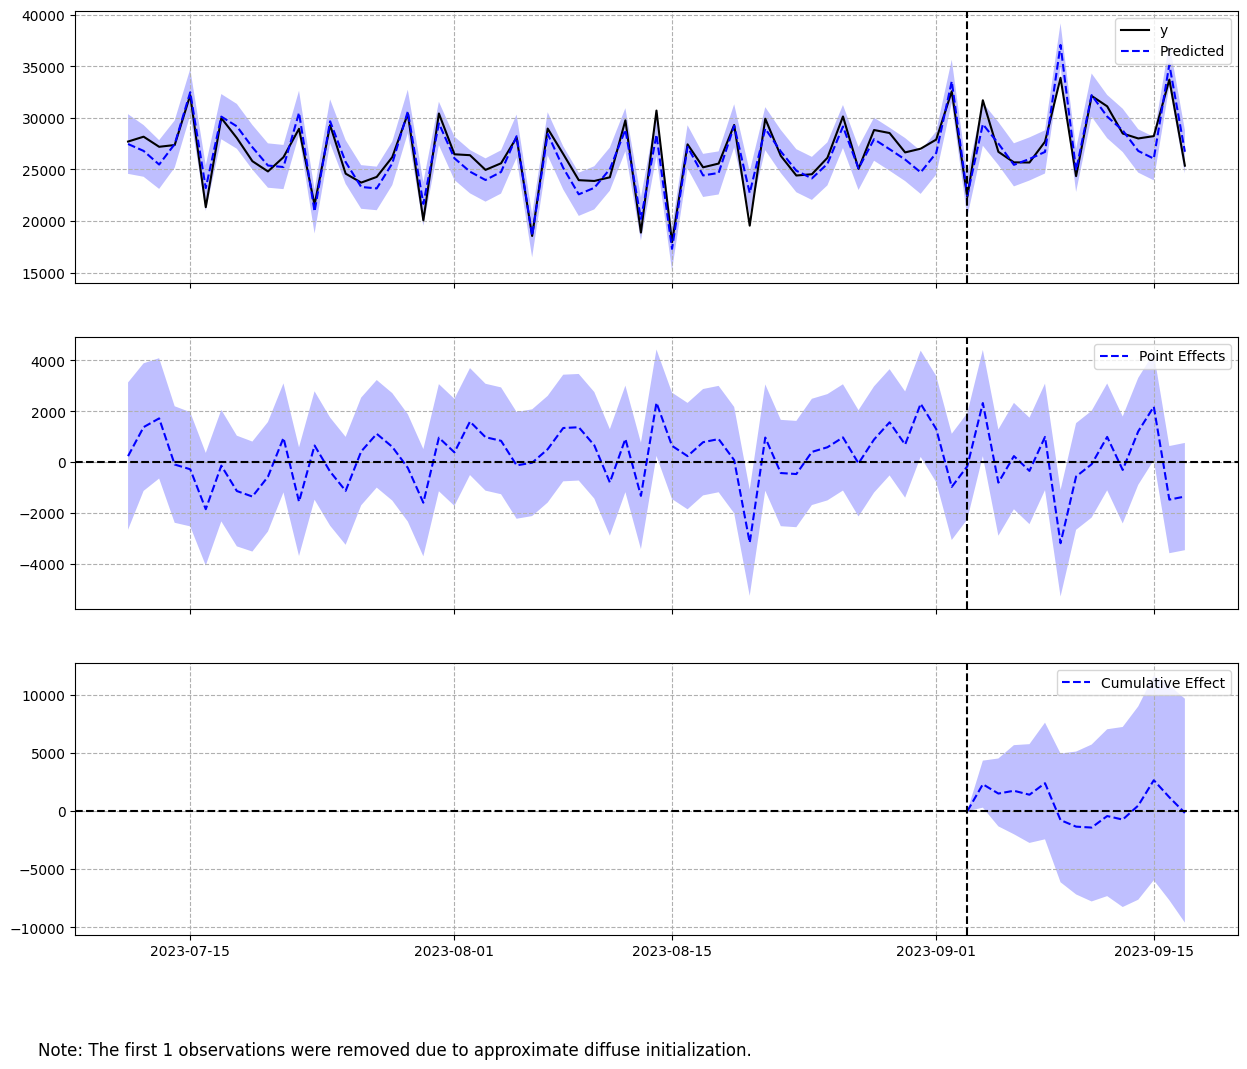

In [38]:
print('number_of_placed_products {}'.format(model3.p_value))
model3.plot()

### Final check

In [39]:
# Be aware that the can be some small changes in the p values as everytime 
# that the model runs, it gets different values.
results_df.loc[[results_df['total_rank'].idxmin()]]

,Group,p_value_number_of_placed_products,p_value_perc_products_pna,p_value_UIPO,rank_p_value_number_of_placed_products,rank_p_value_perc_products_pna,rank_p_value_UIPO,total_rank
4,"{""columns"":[""order_descriptors.store_address_i...",0.492507,0.490509,0.0,1.0,1.0,5.0,7.0


In [40]:
rw.write_file(df_group_config, 'SPM_group_creator_renameXXX.csv')